<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Create-the-dataset" data-toc-modified-id="Create-the-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create the dataset</a></span></li><li><span><a href="#Decomopose-timeseries" data-toc-modified-id="Decomopose-timeseries-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Decomopose timeseries</a></span></li><li><span><a href="#LSTM-model" data-toc-modified-id="LSTM-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>LSTM model</a></span></li><li><span><a href="#In-sample-prediction" data-toc-modified-id="In-sample-prediction-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>In-sample prediction</a></span></li><li><span><a href="#Out-sample-prediction" data-toc-modified-id="Out-sample-prediction-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Out-sample prediction</a></span></li><li><span><a href="#Predicting-even-more-steps-forward" data-toc-modified-id="Predicting-even-more-steps-forward-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Predicting even more steps forward</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

**What?** Making out-of-sample prediction with a multi-step LSTM Models

</font>
</div>

# Imports
<hr style="border:2px solid black"> </hr>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import numpy as np
from xgboost import plot_importance
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error

rcParams['figure.figsize'] = 17, 8
rcParams['font.size'] = 20

# Helper functions
<hr style="border:2px solid black"> </hr>

In [4]:
def plotLearningHistory(history, useLogScale=False):
    """Plot learning history.
    """

    epochs = len(history.history["loss"])
    x = range(0, epochs)

    rcParams['figure.figsize'] = 15, 5
    rcParams['font.size'] = 20

    fig, ax = plt.subplots()
    ax.plot(x, history.history["loss"], 'r-', lw=3, label='Train')

    ax.legend()
    plt.xlabel('Epochs')
    plt.ylabel("MSE")
    plt.title('Training history')

    ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which='major', direction='in', length=10, width=2)
    ax.tick_params(which='minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    ax.minorticks_on()

    if useLogScale == True:
        plt.yscale('log')
    plt.show()

# Create the dataset
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- We want to create a time series that has a constant decay over time which we can predict with a naked eye.
- The goal is to see if a LSTM model can learn the trend and provide a multi-step prediction into the future. 
- To render the problem a little **bit more challenging** we have addded some noise. This was sampled randomly from a normal distribution.

</font>
</div>

667 667


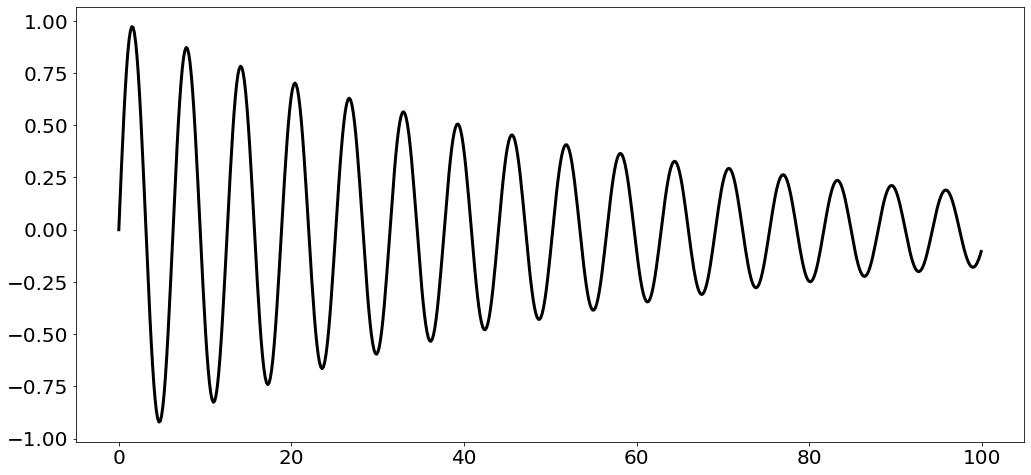

In [5]:
def SinDumpedSignal(n_max, factor):
    """Sine dumped signal
    """
    n = np.arange(0, n_max, 0.15)
    return n, np.sin(n) * 2 ** (-n * factor)


X, Y = SinDumpedSignal(100, 0.025)
print(len(X), len(Y))
plt.plot(X, Y, "-k", lw=3)

In [6]:
noise = np.random.normal(0,0.015,len(Y))

In [7]:
df = pd.DataFrame()
df["cycle"] = np.array(X) 
df["response"] = np.array(Y)
df["responsePlusNoise"] = np.array(Y) + noise

In [8]:
df = df.dropna(how = 'any', axis = 0) 

In [9]:
df.head(5)

,cycle,response,responsePlusNoise
0,0.00,0.000000,0.007184
1,0.15,0.149050,0.162574
2,0.30,0.293988,0.269644
3,0.45,0.431587,0.440551
4,0.60,0.558802,0.546960


In [10]:
df.shape

(667, 3)

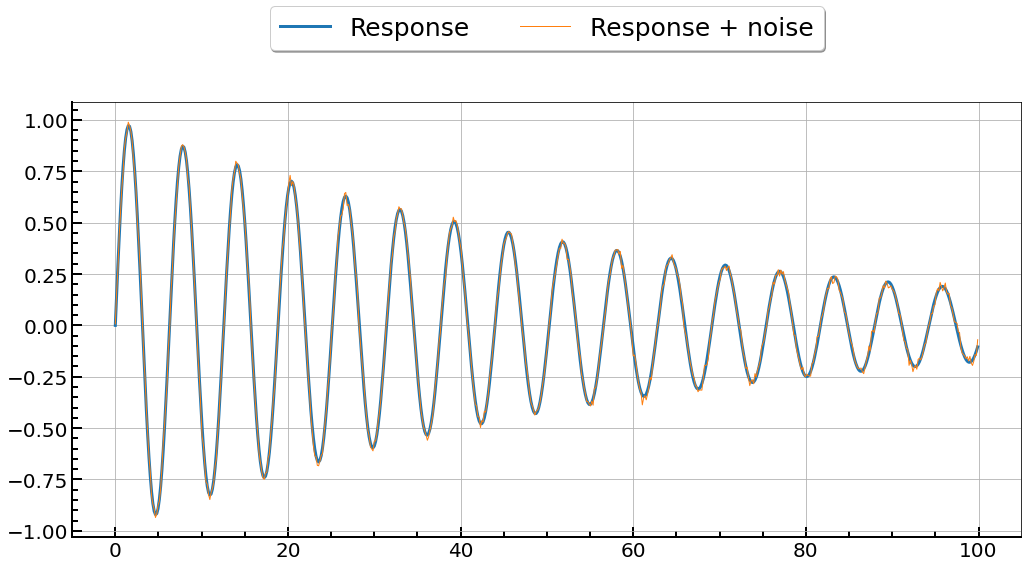

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(df["cycle"], df["response"], "-", lw=3, label="Response")
plt.plot(df["cycle"], df["responsePlusNoise"],
         "-", lw=1, label="Response + noise")

ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.grid()
ax.minorticks_on()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
          ncol=2, fontsize=25, fancybox=True, shadow=True)

# Decomopose timeseries
<hr style="border:2px solid black"> </hr>

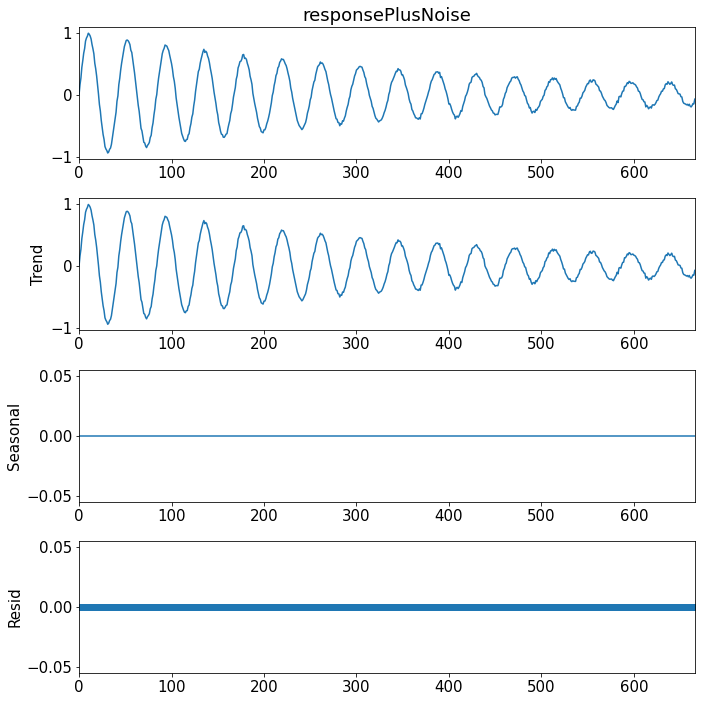

In [14]:
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['font.size'] = 15
rcParams['figure.figsize'] = 10, 10

result = seasonal_decompose(
    df["responsePlusNoise"], model='additive', period=1)
result.plot()
plt.show()

# LSTM model
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-info">
<font color=black>

- A **multi-step** time series forecasting problem requires a prediction of multiple time steps into the future.

- There are **two main types** of LSTM models that can be used for multi-step forecasting; they are:
    - Vector Output Model
    - Encoder-Decoder Model

- We'll concentrate on the first one.
  
</font>
</div>

In [10]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    """Split a univariate sequence into samples

    sequence = univariate series, meaning there is only
    one target we'd like to predict
    n_step_in = how many step back do you want to keep?
    n_step_out = how many steps forwrd do you want to keep?
    """

    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [103]:
# To see how this re-arrange the sequence consider this exampple
seqTest = range(10)
inputs, outputs = split_sequence(seqTest, 4, 3)
for i in range(len(inputs)):
    print(inputs[i], outputs[i])

[0 1 2 3] [4 5 6]
[1 2 3 4] [5 6 7]
[2 3 4 5] [6 7 8]
[3 4 5 6] [7 8 9]


<div class="alert alert-block alert-info">
<font color=black>

- One of the question I still need to answer is the following: is **n_steps_in < n_steps_out** a rule? 
- Does it come from common sense?
- In our case we'd like to look anything between 50 to 100 steps into the future.

</font>
</div>

In [12]:
seq = df["responsePlusNoise"]
print(len(seq))

667


In [13]:
n_steps_in, n_steps_out = 80, 25
X, y = split_sequence(seq, n_steps_in, n_steps_out)

In [14]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(563, 80, 1)

In [37]:
model = Sequential()
model.add(LSTM(250, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(250, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [38]:
# Fit model
history = model.fit(X, y, epochs = 25, verbose = 1)

Epoch 1/25
18/18 [==============================] - 3s 112ms/step - loss: 0.0606
Epoch 2/25
18/18 [==============================] - 2s 105ms/step - loss: 0.0057
Epoch 3/25
18/18 [==============================] - 2s 107ms/step - loss: 0.0015
Epoch 4/25
18/18 [==============================] - 2s 106ms/step - loss: 6.5612e-04
Epoch 5/25
18/18 [==============================] - 2s 106ms/step - loss: 5.6237e-04
Epoch 6/25
18/18 [==============================] - 2s 106ms/step - loss: 4.5486e-04
Epoch 7/25
18/18 [==============================] - 2s 107ms/step - loss: 4.3511e-04
Epoch 8/25
18/18 [==============================] - 2s 105ms/step - loss: 4.0938e-04
Epoch 9/25
18/18 [==============================] - 2s 108ms/step - loss: 3.9424e-04
Epoch 10/25
18/18 [==============================] - 2s 110ms/step - loss: 3.6244e-04
Epoch 11/25
18/18 [==============================] - 2s 112ms/step - loss: 3.4813e-04
Epoch 12/25
18/18 [==============================] - 2s 111ms/step - loss: 

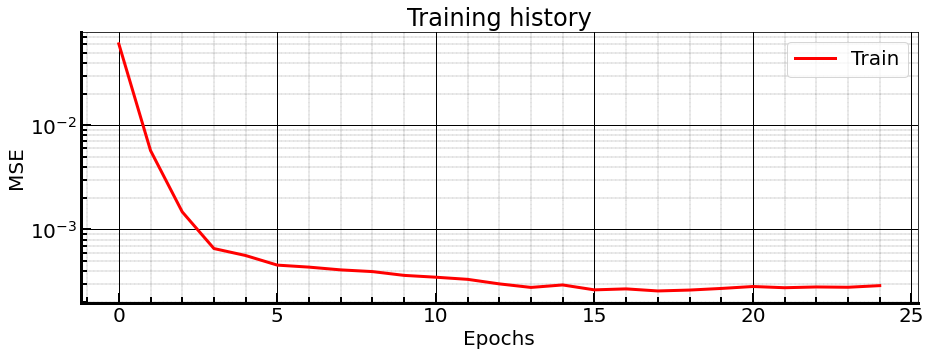

In [39]:
plotLearningHistory(history, useLogScale = True)

# In-sample prediction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- In-sample prediction means we are going to see how well the model predicts data that it has seen before.
- We'll consider the last part of the series **-1**.
- Remember that that we are using 50 samples before to predict 25 after. `n_steps_in, n_steps_out = 50, 25`

</font>
</div>

In [40]:
y[-1]

array([ 0.15823703,  0.17001466,  0.11211176,  0.14240641,  0.07829776,
        0.06247231,  0.07909853,  0.01443062, -0.015163  , -0.06792037,
       -0.10712574, -0.09697601, -0.11417715, -0.11784395, -0.15092534,
       -0.15459685, -0.15872414, -0.17664255, -0.18697825, -0.17295642,
       -0.17130196, -0.15829023, -0.1339517 , -0.12843684, -0.09817013])

In [41]:
# We are using reshape(-1,) just because it easier to print the results
X[-1].reshape(-1,)

array([ 0.13003287,  0.06435411,  0.05804051,  0.02801413,  0.00307034,
       -0.04264527, -0.07182923, -0.11115779, -0.13826547, -0.14236617,
       -0.16003815, -0.19899068, -0.23858729, -0.22787782, -0.21068864,
       -0.20774829, -0.21428746, -0.19752797, -0.16410389, -0.15125432,
       -0.16497415, -0.09483862, -0.09209539, -0.05764253, -0.01301872,
        0.02505438,  0.0426384 ,  0.09142572,  0.11909483,  0.12606577,
        0.14372093,  0.18426606,  0.18989692,  0.19182817,  0.23415688,
        0.20213575,  0.2075183 ,  0.22318903,  0.17365949,  0.18197888,
        0.15225978,  0.1522382 ,  0.09079605,  0.06756745,  0.06026344,
        0.01156323, -0.03293331, -0.06584152, -0.06108571, -0.09893231,
       -0.13018902, -0.1428392 , -0.17031598, -0.1816834 , -0.2004439 ,
       -0.201954  , -0.17989636, -0.18409271, -0.18371953, -0.15912005,
       -0.15849695, -0.13972101, -0.13517797, -0.09184853, -0.06300236,
       -0.04521211,  0.01285325,  0.01003136,  0.02634618,  0.08

In [42]:
# Demonstrate prediction
x_input = X[-1]
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose = 0)
print(yhat[0])

[ 0.16423717  0.15140322  0.12963593  0.11420238  0.08937305  0.06283258
  0.03406031  0.00937265 -0.02249184 -0.04704452 -0.06810813 -0.09686144
 -0.11340102 -0.13043095 -0.15028003 -0.16164637 -0.17222074 -0.17713563
 -0.1789022  -0.17844337 -0.16686514 -0.16216439 -0.14478965 -0.12826562
 -0.10365631]


In [43]:
for i in range(len(yhat[0])):
    print("Target: ", str(y[-1][i]), ", predicted: ", str(yhat[0][i]))

Target:  0.15823703489465213 , predicted:  0.16423717
Target:  0.17001465762700016 , predicted:  0.15140322
Target:  0.11211175689928314 , predicted:  0.12963593
Target:  0.14240641321534386 , predicted:  0.11420238
Target:  0.07829775684481055 , predicted:  0.08937305
Target:  0.06247231079521602 , predicted:  0.06283258
Target:  0.07909853183253718 , predicted:  0.034060314
Target:  0.01443062048599297 , predicted:  0.009372654
Target:  -0.015163001532609185 , predicted:  -0.022491835
Target:  -0.06792036608702981 , predicted:  -0.047044516
Target:  -0.10712573760072944 , predicted:  -0.068108134
Target:  -0.09697600532237255 , predicted:  -0.096861444
Target:  -0.11417714611556203 , predicted:  -0.11340102
Target:  -0.11784395065940063 , predicted:  -0.13043095
Target:  -0.15092534016075262 , predicted:  -0.15028003
Target:  -0.15459685122750128 , predicted:  -0.16164637
Target:  -0.1587241359941297 , predicted:  -0.17222074
Target:  -0.1766425530326415 , predicted:  -0.17713563
Tar

In [44]:
# Predicting the accuracy
print("MSE= ", mean_squared_error(y[-1], yhat[0]))
print("MSE= ", mean_absolute_error(y[-1], yhat[0])) 

MSE=  0.00025371311524135436
MSE=  0.01090501425932207


# Out-sample prediction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-info">
<font color=black>

- In-of-sample prediction are those predictions the model has seen before.
- So we have **80 steps** as input for **25 steps** as output. 
- We'd lilke to see if the model can predict the last 25 value of the series. This means we need to feed the previous 80 points which exaplains the `[-80-25:-25] = [-105:-25]`

</font>
</div>

In [46]:
n_steps_in

80

In [47]:
n_steps_out

25

In [70]:
x_input_new = []
for i in X[-1].reshape(-1,):
    x_input_new.append(i)
for j in y[-1]:
    x_input_new.append(j)

# we need the last 80+25 input as we are predicting on the last 25
x_input_new = x_input_new[-105:-25]
print(len(x_input_new))  

x_input_new = np.array(x_input_new)
x_input_new = x_input_new.reshape((1, n_steps_in, n_features))
print(x_input_new.shape)
yhat_new = model.predict(x_input_new, verbose=0)

80
(1, 80, 1)


In [100]:
delta = df["cycle"].values[1] - df["cycle"].values[0]
delta

0.15

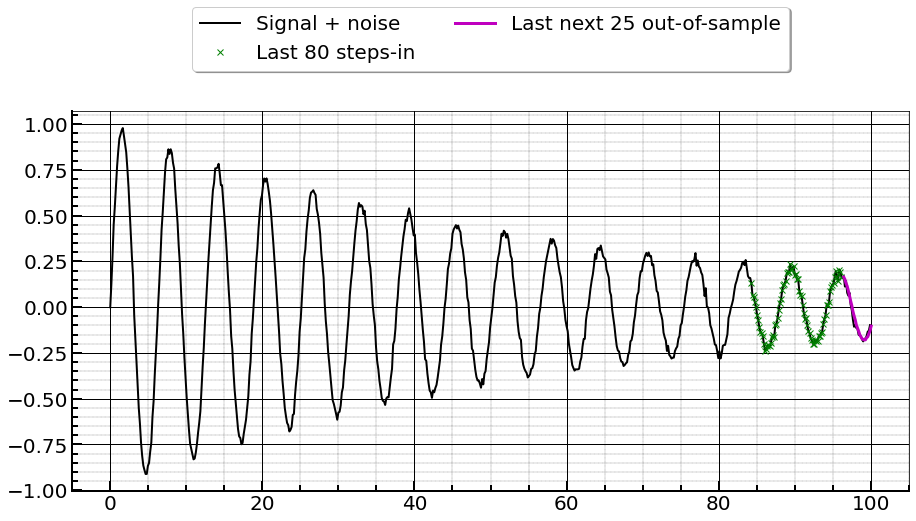

In [101]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

plt.plot(df["cycle"], df["responsePlusNoise"],
         "-k", lw=2, label="Signal + noise")

a = df["cycle"].values
b = df["responsePlusNoise"].values


# We have taken the last 50 but keep in mind there is a lag
plt.plot(a[-105:-25], b[-105:-25], "gx", lw=2, label='Last 80 steps-in')

c = []
dummy = 0
for i in range(len(yhat_new[-1])):
    dummy += 0.15
    c.append(dummy + a[-25])

plt.plot(c, yhat_new[0], "m-", lw=3, label='Last next 25 out-of-sample')

ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=True, shadow=True)

plt.grid(True)

<div class="alert alert-info">
<font color=black>

- One interesting observation is that the prediction is always much more smooth than the actual training samples.
- Is that connected to the fact it is said the ANNs are said be good at **filtering out noise**?

</font>
</div>

# Predicting even more steps forward
<hr style="border:2px solid black"> </hr>

<div class="alert alert-info">
<font color=black>

- What if we want to predict even more steps?
- We have to decide whether we are going to retrain the model or not?
- In this cell we are **NOT** going to retrain the model and we'll check if the model has learnt the decay trend.
- **The important** point here is to understand that the output will eventually become inputs, in **self-feeding manner**.

</font>
</div>

In [51]:
input_ = x_input_new.reshape(-1,1)
input_.shape
input_ = list(input_)
input_ = [i[0] for i in input_]

In [52]:
input_

[0.13003286558665855,
 0.06435411393376021,
 0.058040509127743126,
 0.02801412811408951,
 0.0030703362179893383,
 -0.04264527167327571,
 -0.07182922823799615,
 -0.11115779182007621,
 -0.13826546568300163,
 -0.1423661681079624,
 -0.16003815297858093,
 -0.19899067570766288,
 -0.23858728918008576,
 -0.22787782019313135,
 -0.21068864487728556,
 -0.207748289904281,
 -0.21428746383647862,
 -0.19752796673485476,
 -0.1641038890195078,
 -0.15125431982467574,
 -0.16497414694747506,
 -0.09483861548840321,
 -0.09209539459692971,
 -0.057642533210226596,
 -0.01301872467325289,
 0.025054383120022432,
 0.04263839609957993,
 0.0914257229392894,
 0.11909482972787677,
 0.12606577469940494,
 0.1437209270897605,
 0.18426605755580458,
 0.18989692299216362,
 0.19182817341473857,
 0.23415687569020993,
 0.2021357457051207,
 0.20751830447278746,
 0.22318903351270583,
 0.17365948828109967,
 0.18197887966463458,
 0.15225977555716513,
 0.15223819616565148,
 0.090796045742408,
 0.06756744670046322,
 0.0602634397720

In [81]:
x_input[-80:]

array([[[ 0.13003287],
        [ 0.06435411],
        [ 0.05804051],
        [ 0.02801413],
        [ 0.00307034],
        [-0.04264527],
        [-0.07182923],
        [-0.11115779],
        [-0.13826547],
        [-0.14236617],
        [-0.16003815],
        [-0.19899068],
        [-0.23858729],
        [-0.22787782],
        [-0.21068864],
        [-0.20774829],
        [-0.21428746],
        [-0.19752797],
        [-0.16410389],
        [-0.15125432],
        [-0.16497415],
        [-0.09483862],
        [-0.09209539],
        [-0.05764253],
        [-0.01301872],
        [ 0.02505438],
        [ 0.0426384 ],
        [ 0.09142572],
        [ 0.11909483],
        [ 0.12606577],
        [ 0.14372093],
        [ 0.18426606],
        [ 0.18989692],
        [ 0.19182817],
        [ 0.23415688],
        [ 0.20213575],
        [ 0.2075183 ],
        [ 0.22318903],
        [ 0.17365949],
        [ 0.18197888],
        [ 0.15225978],
        [ 0.1522382 ],
        [ 0.09079605],
        [ 0

In [97]:
loop = 18

counter = 0
import copy
x_input_new_ = copy.deepcopy(input_)
while counter < loop:
    counter +=1
    
    # We need the last 80 only (again)
    x_input_new_temp = x_input_new_[-80:]
    #print(x_input_new_temp.shape)
    # Make it an array
    x_input_new_temp = np.array(x_input_new_temp)
    #print(x_input_new_temp.shape)
    x_input_new_temp = x_input_new_temp.reshape((1, n_steps_in, n_features))
    #print(x_input_new_temp.shape)
    # new prediction
    yhat_new_temp = model.predict(x_input_new_temp, verbose=0) 
    #print(yhat_new_temp)
    #print(yhat_new_temp.shape)
    for k in yhat_new_temp[0]:
        #x_input_new = x_input_new
        #x_input_new = list(x_input_new)
        #print(x_input_new)
        
        x_input_new_.append(k)     

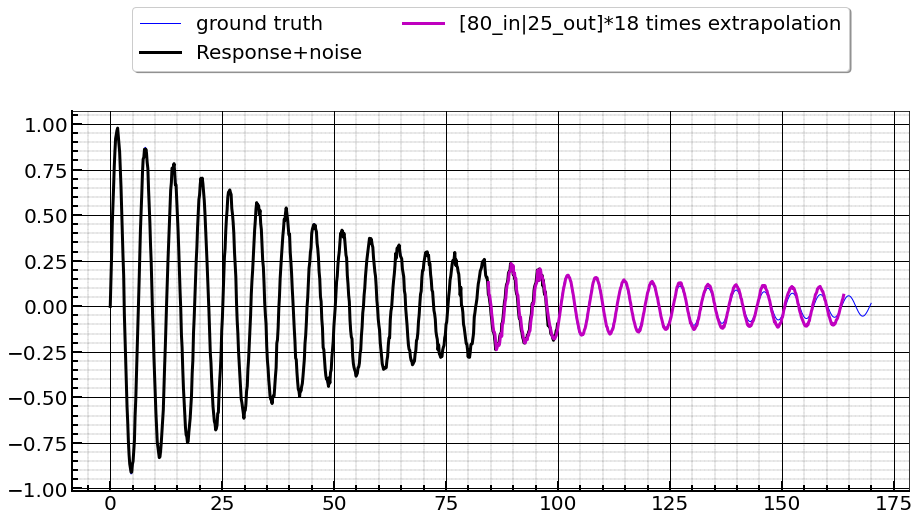

In [98]:
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

# We need this to se if the model has learnt the constant decay trend
xx, yy = SinDumpedSignal(170, 0.025)
plt.plot(xx, yy, "b-", lw=1, label="ground truth")


plt.plot(df["cycle"], df["responsePlusNoise"],
         "-k", lw=3, label="Response+noise")

a = df["cycle"].values
b = df["responsePlusNoise"].values


# We have taken the last 50 but keep in mind there is a lag
#plt.plot(a[-80:], b[-80:], "gx", lw = 2, label = 'Last 50 steps-in')

c = []
dummy = 0
for i in range(len(x_input_new_)):
    dummy += delta
    c.append(dummy + a[-80-25])

plt.plot(c, x_input_new_, "m-", lw=3,
         label='[80_in|25_out]*'+str(loop)+" times extrapolation")


ax.grid(which="major", linestyle='-', linewidth='1.0', color='k')
ax.grid(which="minor", linestyle='--', linewidth='0.25', color='k')
ax.tick_params(which='major', direction='in', length=10, width=2)
ax.tick_params(which='minor', direction='in', length=6, width=2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.minorticks_on()

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
          ncol=2, fancybox=True, shadow=True)

plt.grid(True)

# Conclusions
<hr style="border:2px solid black"> </hr>

<div class="alert alert-danger">
<font color=black>

- As you can see we extrapolate the whole trend.
- What is difficult is finding out the right inputs. Is the `80_in|25_out` optimal?
- The cherry on the cake would be to add some PI to the prediction.
- Further, will the model learn a non-constant decay trend?

</font>
</div>